In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import hydra
from mmda.utils.calibrate import get_non_conformity_scores

def load_sim_mat_cali(config_path:str="../config", config_name:str="main")->dict:
    """Load the similarity matrix for calibration."""
    with hydra.initialize(version_base=None, config_path=config_path):
        cfg = hydra.compose(config_name=config_name)
        cfg_dataset = cfg["KITTI"]
        return joblib.load(
                Path(
                    cfg_dataset.paths.save_path,
                    f"sim_mat_cali_{cfg_dataset.retrieval_dim}_{cfg_dataset.mask_ratio}.pkl",
                )
                )

def overlap_ratio(hist1:np.ndarray, hist2:np.ndarray)->float:
    """Computes the overlap ratio between two histograms."""
    minima = np.minimum(hist1, hist2)
    intersection = np.sum(minima)
    union = np.sum(hist1) + np.sum(hist2) - intersection
    return intersection / union


### NC C Distributions Overlap Ratio

4606 147
Image-Image  Overlap Ratio:  0.24769371999578643
9212 294
Image-Lidar  Overlap Ratio:  0.2387903023201753
9212 294
Image-Text  Overlap Ratio:  0.20418300653594776
4606 147
Lidar-Lidar  Overlap Ratio:  0.22972743380015048
9212 294
Lidar-Text  Overlap Ratio:  0.20562765841422165
4606 147
Text-Text  Overlap Ratio:  0.26770639153106773


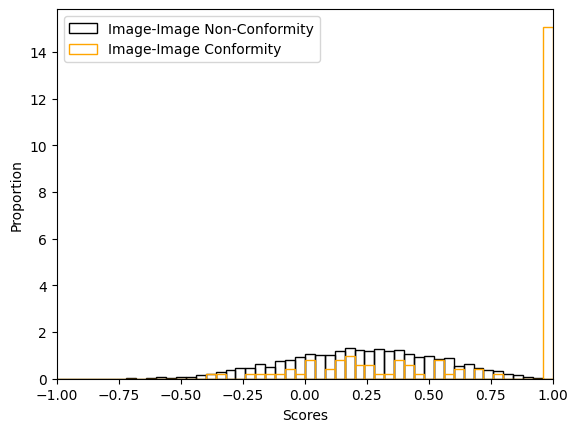

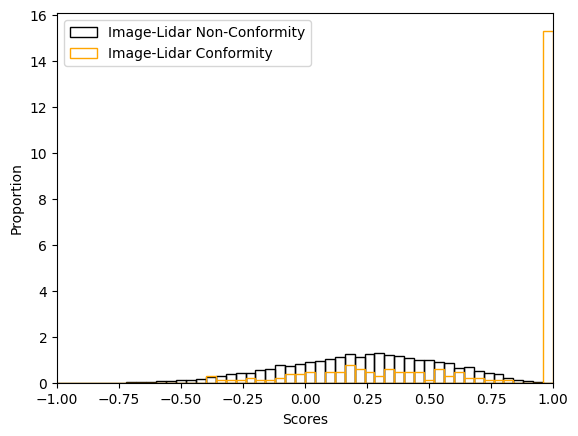

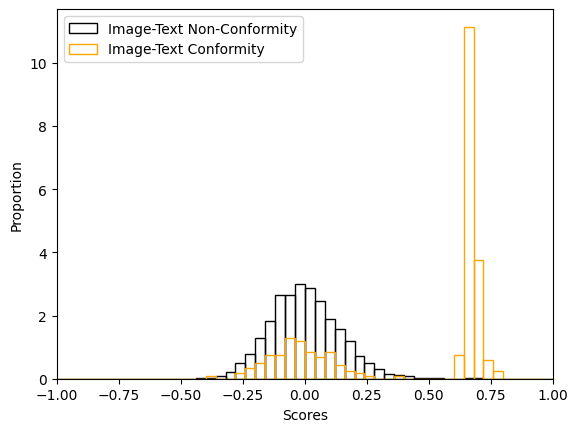

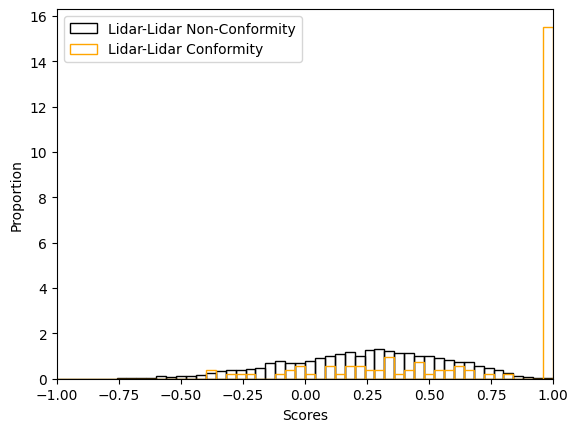

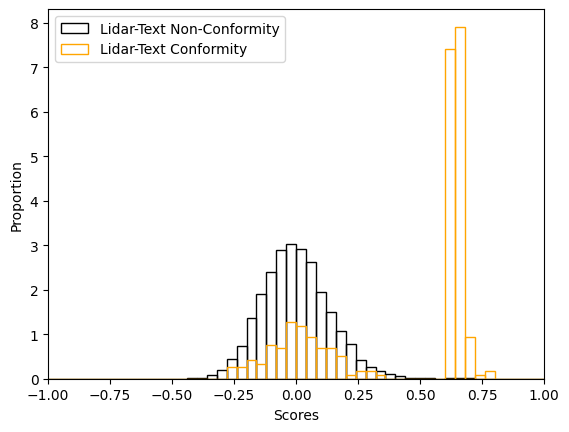

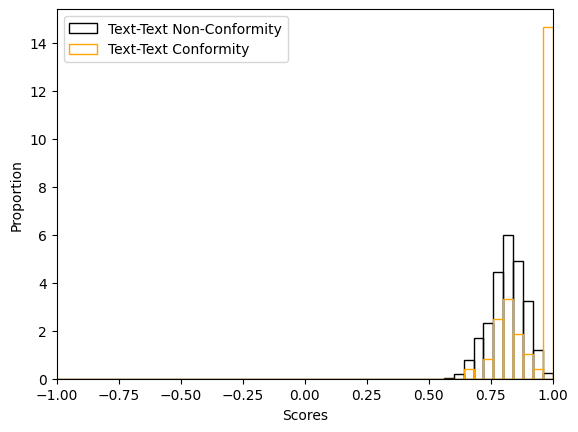

In [18]:
IMAGE = 0
LIDAR = 1
TEXT = 2

bin_edges = np.array(range(51))/25-1
modalities = ["Image", "Lidar", "Text"]

data = load_sim_mat_cali()

for i in range(3):
    for j in range(i, 3):
        plt.figure()
        nc_scores, c_scores = get_non_conformity_scores(data, i, j)
        print(len(nc_scores), len(c_scores))
        nc_fig = plt.hist(nc_scores, bins=bin_edges, fill=None, edgecolor="black", density=True, \
                        label=modalities[i] + "-" + modalities[j]+" Non-Conformity")
        c_fig = plt.hist(c_scores, bins=bin_edges, fill=None, edgecolor="orange", density=True, \
                        label=modalities[i] + "-" + modalities[j]+" Conformity")
        plt.xlabel("Scores")
        plt.ylabel("Proportion")
        plt.xlim(-1,1)
        plt.legend()
        plt.plot()

        print(modalities[i] + "-" + modalities[j], " Overlap Ratio: ", overlap_ratio(nc_fig[0], c_fig[0]))

### Nonconformity distributions

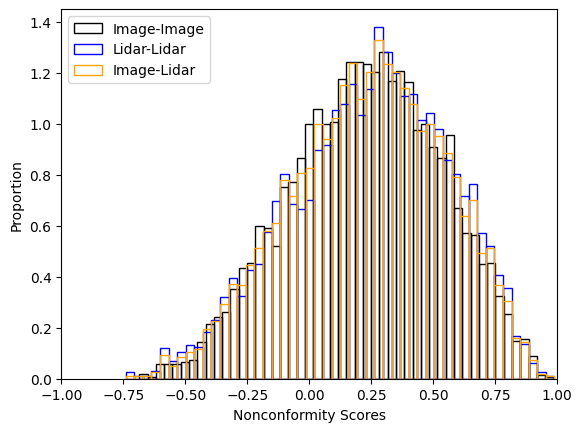

In [19]:
nc_scores_0, _ = get_non_conformity_scores(data, IMAGE, IMAGE)
plt.hist(nc_scores_0, bins=50, fill=None, edgecolor="black", density=True, label="Image-Image")

nc_scores_1, _ = get_non_conformity_scores(data, LIDAR, LIDAR)
plt.hist(nc_scores_1, bins=50, fill=None, edgecolor="blue", density=True, label = "Lidar-Lidar")

nc_scores, _ = get_non_conformity_scores(data, IMAGE, LIDAR)
plt.hist(nc_scores, bins=50, fill=None, edgecolor="orange", density=True, label = "Image-Lidar")

plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.xlim(-1,1)
plt.legend()

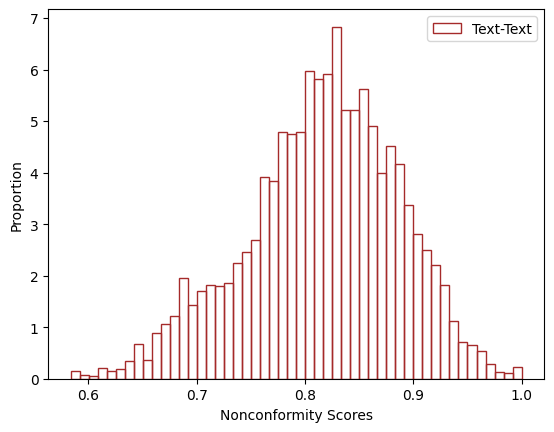

In [20]:
nc_scores_22, c_scores_22= get_non_conformity_scores(data, TEXT, TEXT)
plt.hist(nc_scores_22, bins=50, fill=None, edgecolor="brown", density=True, label = "Text-Text")
plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.legend(title="Similarity of negative pairs")
plt.legend()

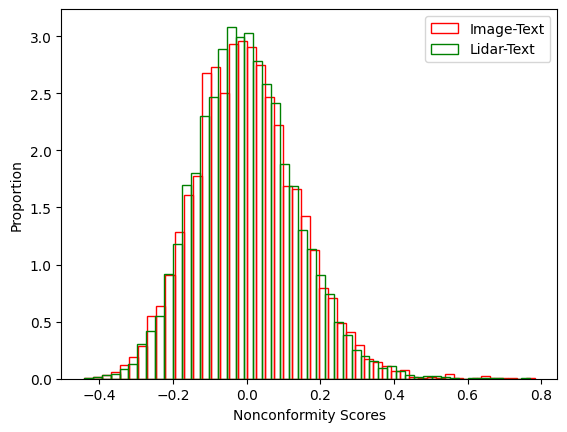

In [21]:
nc_scores_33, c_scores_33 = get_non_conformity_scores(data, IMAGE, TEXT)
plt.hist(nc_scores_33, bins=50, fill=None, edgecolor="red", density=True, label="Image-Text")

nc_scores_44, c_scores_44 = get_non_conformity_scores(data, LIDAR, TEXT)
plt.hist(nc_scores_44, bins=50, fill=None, edgecolor="green", density=True, label="Lidar-Text")

plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.legend()

In [24]:
from mmda.utils.spearman_utils import spearman_rank_coefficient

def correlation(data: dict, modalities1: tuple[int, int] = (0, 0), modalities2: tuple[int, int] = (1, 1)) -> np.ndarray:
    """Compute the correlation between two modalities."""
    m1, m2 = [], []
    for k in data:
        mat, label = data[k]
        m1.append(mat[modalities1[0]][modalities1[1]])
        m2.append(mat[modalities2[0]][modalities2[1]])
    return np.corrcoef(m1, m2)

modalities = ["Image", "Lidar", "Text"]

for i in range(3):
    for j in range(i, 3):
        for k in range(j, 3):
            for l in range(k, 3): # noqa: E741
                # corr = correlation(data, modalities1=(i,j), modalities2=(k,l))[0][1]
                # print(modalities[i], "-", modalities[j], " ", modalities[k], "-", modalities[l], " ", corr)
                scores = [data[_][0][i][j] for _ in data]
                scores_k = [data[_][0][k][l] for _ in data]
                r, _, _ = spearman_rank_coefficient(np.array(scores), np.array(scores_k))
                print(modalities[i], "-", modalities[j], " ", modalities[k], "-", modalities[l], " ", r)


Image - Image   Image - Image   1.0
Image - Image   Image - Lidar   1.0
Image - Image   Image - Text   0.007341930989206102
Image - Image   Lidar - Lidar   0.00122122458184859
Image - Image   Lidar - Text   0.019688407865281476
Image - Image   Text - Text   -0.009857026966098026
Image - Lidar   Lidar - Lidar   0.00122122458184859
Image - Lidar   Lidar - Text   0.019688407865281476
Image - Lidar   Text - Text   -0.009857026966098026
Image - Text   Text - Text   -0.003117252337814236
Lidar - Lidar   Lidar - Lidar   1.0
Lidar - Lidar   Lidar - Text   0.013313832340271947
Lidar - Lidar   Text - Text   0.017159768855341206
Lidar - Text   Text - Text   0.018496638055982895
Text - Text   Text - Text   1.0
